# Setup & import libraries

In [79]:
DATASET = 'GTSRB'
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [80]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [81]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

In [82]:
from utilities.pathManager import fetchPaths

paths = fetchPaths(base, DATASET, '', False)
path_data = paths['data']

path_data

PosixPath('/home/ah19/runtime-monitoring/datasets/GTSRB')

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from PIL import Image
import time
from fastprogress import progress_bar
import csv

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchinfo import summary

torch.set_default_dtype(torch.float64)

In [84]:
from utilities.utils import get_labels, get_device, get_dataLoader, get_dataset, show_images_loader, get_mean_std
from models.transformers import transformers

### Device

In [85]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

### Targets

In [86]:
feature_names = get_labels(DATASET)

# GTSRB Dataset - PyTorch

In [87]:
tf = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32))
])

gtsrb_train = torchvision.datasets.GTSRB(root=path_data, split='train', download=True, transform=tf)
gtsrb_test = torchvision.datasets.GTSRB(root=path_data, split='test', download=True, transform=tf)

In [88]:
# to calculate manually
# gtsrb_cls_count_train = get_class_weights(DataLoader(gtsrb_train, 512))

# already calculated
gtsrb_cls_count_train = np.array([ 150., 1500., 1500.,  960., 1320., 1260.,  300.,  960.,  960.,
        990., 1350.,  900., 1410., 1440.,  540.,  420.,  300.,  750.,
        810.,  150.,  240.,  240.,  270.,  360.,  180., 1020.,  420.,
        180.,  360.,  180.,  300.,  540.,  180.,  480.,  300.,  810.,
        270.,  150., 1380.,  210.,  240.,  180.,  180.])

In [89]:
# to calculate manually
# gtsrb_cls_count_test = get_class_weights(DataLoader(gtsrb_test, 512))

# already calculated
gtsrb_cls_count_test = np.array([ 60., 720., 750., 450., 660., 630., 150., 450., 450., 480., 660.,
       420., 690., 720., 270., 210., 150., 360., 390.,  60.,  90.,  90.,
       120., 150.,  90., 480., 180.,  60., 150.,  90., 150., 270.,  60.,
       210., 120., 390., 120.,  60., 690.,  90.,  90.,  60.,  90.])

In [90]:
# is class weights are close between train and test within 1%
print('Is class weights are close between train and test within 1%:',
      np.allclose(
        gtsrb_cls_count_test / len(gtsrb_test),
        gtsrb_cls_count_train / len(gtsrb_train),
        atol=1e-2
    ))

Is class weights are close between train and test within 1%: True


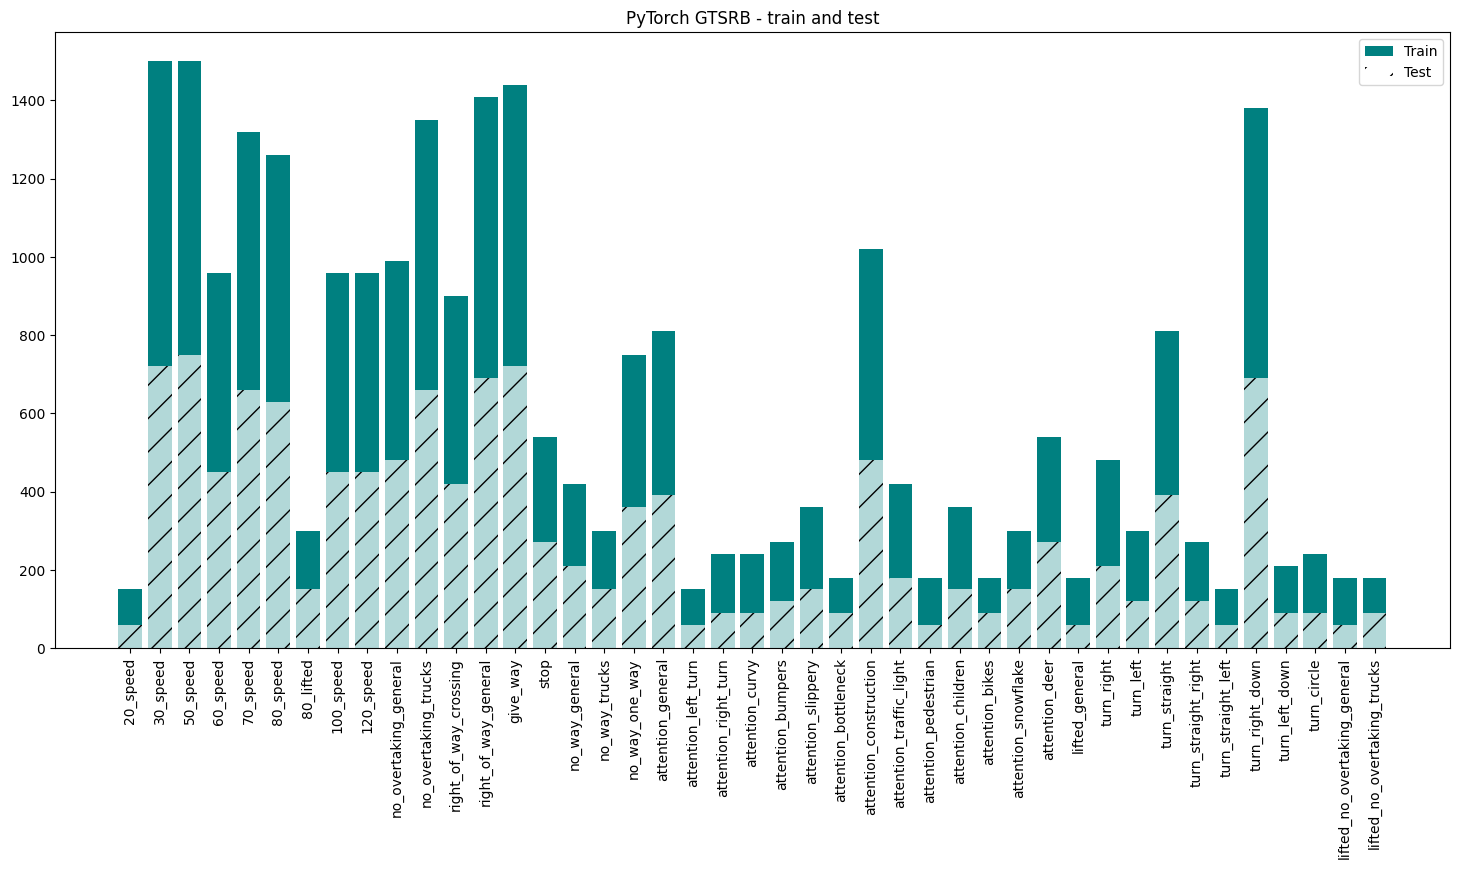

In [91]:
plt.figure(figsize=(18, 8))
plt.bar(height=gtsrb_cls_count_train, x=list(feature_names.values()), color='teal', label='Train')
plt.bar(height=gtsrb_cls_count_test, x=list(feature_names.values()), color='white', alpha=.70, hatch='/', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.title('PyTorch GTSRB - train and test')
plt.show()

# Load Custom Data


In [92]:
class GTSRB(Dataset):
    def __init__(self, root, csv_file, transform=None):
        self.root = root
        self.data = pd.read_csv(root / csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = Image.open(self.root / self.data.iloc[index, 0])
        label = torch.tensor( self.data.iloc[index, 1] )
        
        if self.transform:
            img = self.transform(img)

        return (img, label)

In [93]:
tf = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32))
])

tf_train = transformers[DATASET.lower()]['train']
tf_test = transformers[DATASET.lower()]['test']

train_data = GTSRB(path_data / 'gtsrb_original' / 'trainingset', 'training.csv', tf)
test_data = GTSRB(path_data / 'gtsrb_original' / 'testset', 'test.csv', tf)

In [94]:
test_data.data.columns = [0, 1]
test_data.data.drop(index=0, axis=0, inplace=True)
test_data.data[1] = test_data.data[1].astype(np.int8)

len(train_data), len(test_data)

(39209, 12630)

## Comparison

In [97]:
len(train_data), len(gtsrb_train), len(train_data) - len(gtsrb_train)

(39209, 26640, 12569)

In [98]:
len(test_data) - len(gtsrb_test)

0

In [131]:
train_weights / train_weights.sum() * 100

array([0.53559132, 5.66196537, 5.73847841, 3.59611314, 5.049861  ,
       4.74380882, 1.07118264, 3.67262618, 3.59611314, 3.74913923,
       5.12637405, 3.366574  , 5.35591318, 5.50893927, 1.98933918,
       1.60677395, 1.07118264, 2.83098268, 3.06052182, 0.53559132,
       0.91815655, 0.8416435 , 0.99466959, 1.30072177, 0.68861741,
       3.82565227, 1.53026091, 0.61210436, 1.37723482, 0.68861741,
       1.14769568, 1.98933918, 0.61210436, 1.75724961, 1.07118264,
       3.06052182, 0.99466959, 0.53559132, 5.27940014, 0.76513045,
       0.91815655, 0.61210436, 0.61210436])

In [99]:
train_weights = train_data.data[1].value_counts().sort_index().to_numpy()
test_weights = test_data.data[1].value_counts().sort_index().to_numpy()

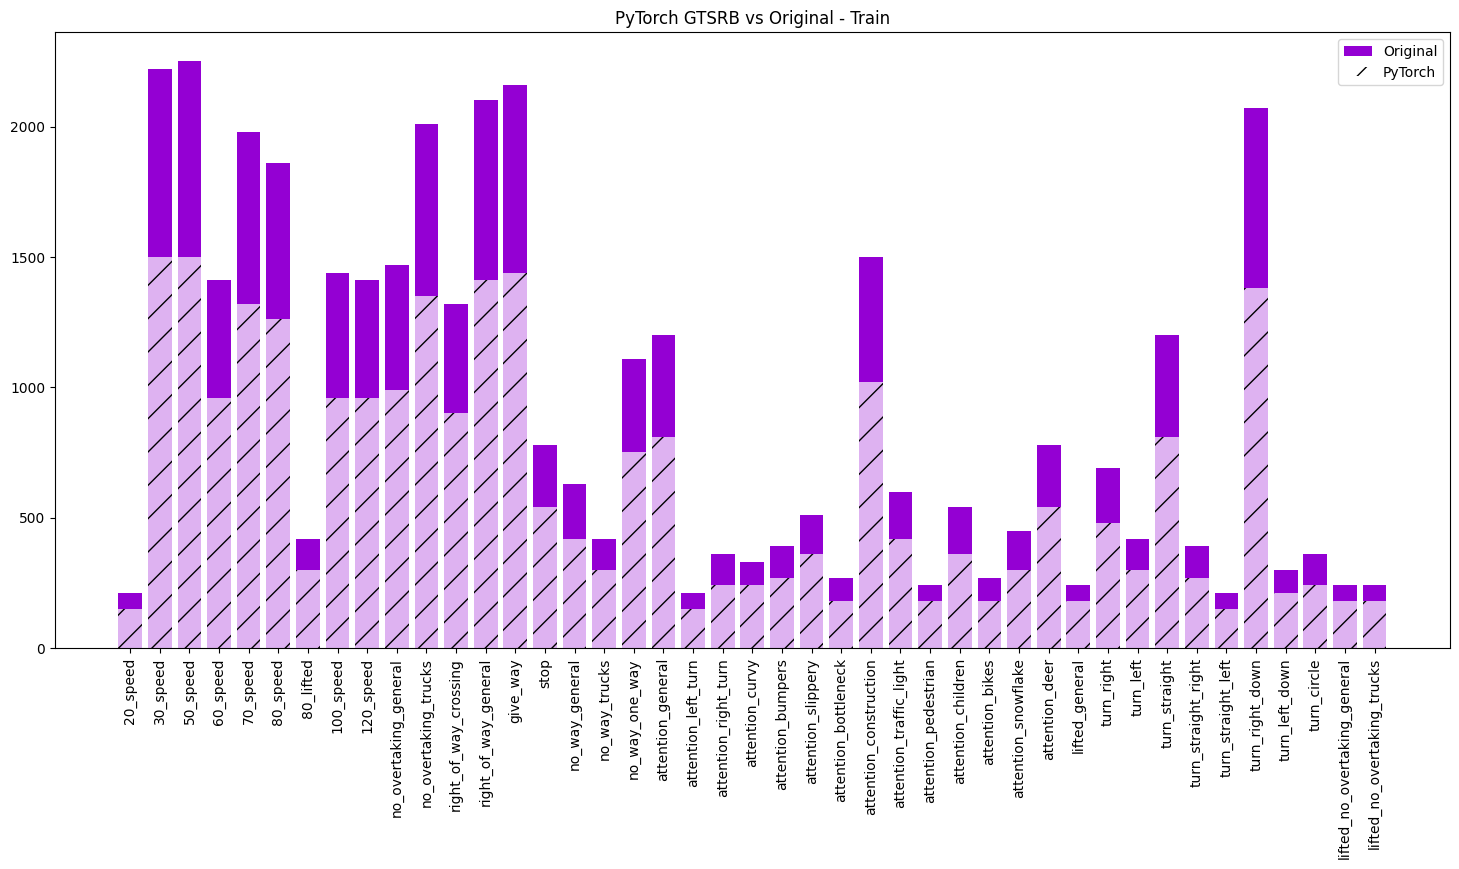

In [100]:
plt.figure(figsize=(18, 8))
plt.bar(height=train_weights, x=list(feature_names.values()), color='darkviolet', label='Original')
plt.bar(height=gtsrb_cls_count_train, x=list(feature_names.values()),  alpha=.70, hatch='/', color='white', label='PyTorch')
plt.xticks(rotation=90)
plt.legend()
plt.title('PyTorch GTSRB vs Original - Train')
plt.show()

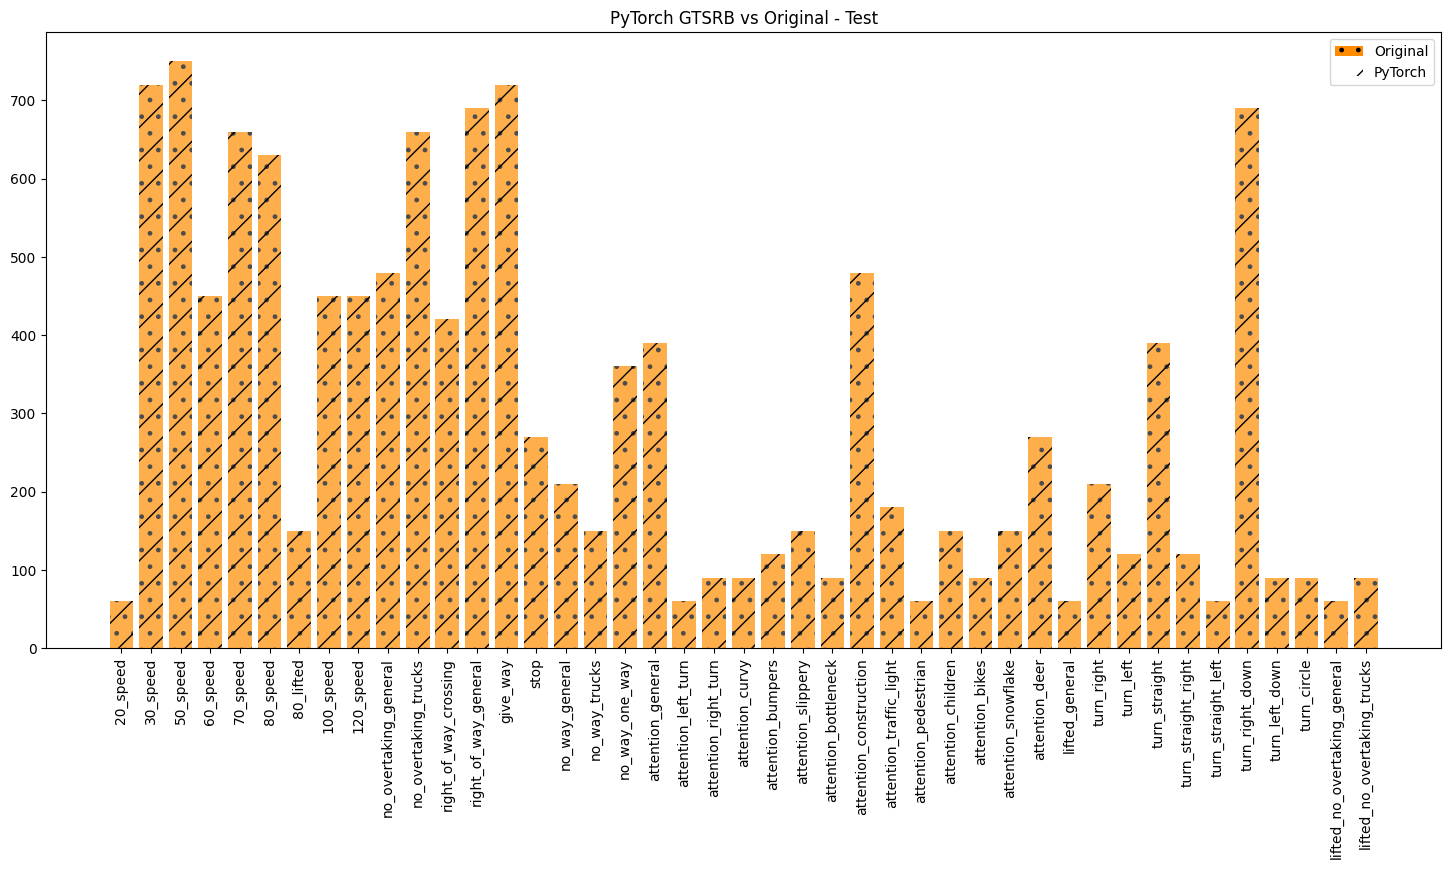

In [101]:
plt.figure(figsize=(18, 8))
plt.bar(height=test_weights, x=list(feature_names.values()), color='darkorange', hatch='.', label='Original')
plt.bar(height=gtsrb_cls_count_test, x=list(feature_names.values()),  alpha=.30, hatch='/', color='white', label='PyTorch')
plt.xticks(rotation=90)
plt.legend()
plt.title('PyTorch GTSRB vs Original - Test')
plt.show()

# Explore image sizes

In [59]:
sizes = [(0,0)] * len(train_data)

for i, p in enumerate(train_data.data[0]):
    sizes[i] = Image.open(train_data.root / p).size
    
sizes_df = pd.DataFrame(sizes, columns=['w', 'h'])

In [77]:
sizes_df.describe()

,w,h
count,39209.000000,39209.000000
mean,50.835880,50.328930
std,24.306933,23.115423
min,25.000000,25.000000
25%,35.000000,35.000000
50%,43.000000,43.000000
75%,58.000000,58.000000
max,243.000000,225.000000


In [78]:
sizes_df.median()

w    43.0
h    43.0
dtype: float64

# Explore Data Augmentation

In [136]:
# t = torch.zeros((5, 1, 10, 10))
# t

In [137]:
# t1 = t + torch.tensor([
#     [[[10]]],
#     [[[100]]],
#     [[[1000]]],
#     [[[10_000]]],
#     [[[100_000]]],
# ])

In [138]:
# t1[4]

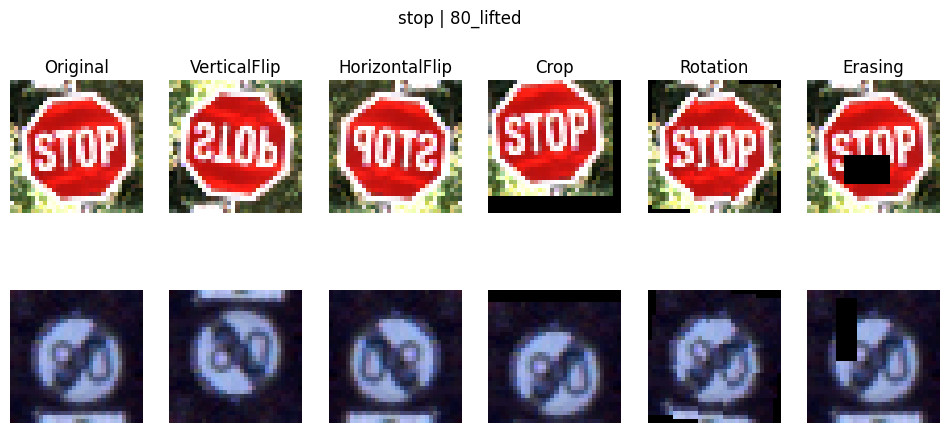

In [125]:
# img, label = next( iter( DataLoader(gtsrb_train, 2, True) ) )
img, label = next( iter( DataLoader(train_data, 10, True) ) )

fig, axs = plt.subplots( 2, 6, figsize=(3 *4, 5) )

[a.set_title(x) for a, x in zip(axs[0], ["Original", "VerticalFlip", "HorizontalFlip", "Crop", "Rotation", "Erasing"])]
[a.set_axis_off() for a in axs[0]]
[a.set_axis_off() for a in axs[1]]

fig.suptitle(f"{feature_names[label[0].item()]} | {feature_names[label[1].item()]}")

t1 = T.RandomVerticalFlip(p=1)
t2 = T.RandomHorizontalFlip(p=1)
t3 = T.RandomCrop((32, 32), padding=4)
t4 = T.RandomRotation((-15, 15))
t5 = T.RandomErasing(scale=(0.05, 0.1),ratio=(0.2, 3.3), p=1)

# temp = img

dim = (1, 2, 3)

img = (img - img.amin(dim, keepdim=True)) / (img.amax(dim, keepdim=True) - img.amin(dim, keepdim=True))

i = 0

axs[0, 0].imshow( img[i].permute(1, 2, 0) )
axs[0, 1].imshow( t1(img[i]).permute(1, 2, 0) )
axs[0, 2].imshow( t2(img[i]).permute(1, 2, 0) )
axs[0, 3].imshow( t3(img[i]).permute(1, 2, 0) )
axs[0, 4].imshow( t4(img[i]).permute(1, 2, 0) )
axs[0, 5].imshow( t5(img[i]).permute(1, 2, 0) )

i = 1

axs[1, 0].imshow( img[i].permute(1, 2, 0) )
axs[1, 1].imshow( t1(img[i]).permute(1, 2, 0) )
axs[1, 2].imshow( t2(img[i]).permute(1, 2, 0) )
axs[1, 3].imshow( t3(img[i]).permute(1, 2, 0) )
axs[1, 4].imshow( t4(img[i]).permute(1, 2, 0) )
axs[1, 5].imshow( t5(img[i]).permute(1, 2, 0) )

plt.show()

# Analyzind Class Weights

In [32]:
def get_class_weights(dataloader):
    c = np.zeros(43)
    for _, label in dataloader:
        c += np.bincount(label.numpy(), minlength=43)
    return c

def get_instance_weights(dataloader, class_weights):
    batch_size = dataloader.batch_size
    weight_classes_normlized = 1 / weight_classes
    weights_intances = torch.zeros(len(dataloader) * batch_size)
    for i, (_, label) in enumerate(dataloader):
        weights_intances[i*batch_size: (i+1)*batch_size] = np.append(weights_intances, weight_classes_normlized[label.numpy()])

    return weights_intances


In [42]:
trainloader = get_dataLoader(train_data, 512*6, num_workers=4)
testloader = get_dataLoader(test_data, 512*2, num_workers=4)

In [54]:
img[0].shape

torch.Size([3, 32, 32])

In [93]:
img.amin((1, 2, 3), keepdim=True).shape

torch.Size([10, 1, 1, 1])

In [44]:
mx = 0
mn = 1000

for img, _ in trainloader:
#     img *= 1./255
    mx = max(mx, img.max().item())
    mn = min(mn, img.min().item())
    
mx, mn

(1.0, 0.0)

In [50]:
# trainloader = get_dataLoader(gtsrb_train, 2048)
# testloader = get_dataLoader(gtsrb_test, 2048)
# train_weights = get_class_weights(trainloader)
# test_weights = get_class_weights(testloader)

In [24]:
train_weights

array([ 210, 2220, 2250, 1410, 1980, 1860,  420, 1440, 1410, 1470, 2010,
       1320, 2100, 2160,  780,  630,  420, 1110, 1200,  210,  360,  330,
        390,  510,  270, 1500,  600,  240,  540,  270,  450,  780,  240,
        689,  420, 1200,  390,  210, 2070,  300,  360,  240,  240])

In [25]:
test_weights

array([ 60, 720, 750, 450, 660, 630, 150, 450, 450, 480, 660, 420, 690,
       720, 270, 210, 150, 360, 390,  60,  90,  90, 120, 150,  90, 480,
       180,  60, 150,  90, 150, 270,  60, 210, 120, 390, 120,  60, 690,
        90,  90,  60,  90])

# Balanced Dataset

In [139]:
train_class_weights = np.divide(train_weights.sum(), train_weights)
test_class_weights = np.divide(test_weights.sum(), test_weights)

In [140]:
train_intance_weights = np.apply_along_axis(lambda x: train_class_weights[x], 0, train_data.data[1])
test_intance_weights = np.apply_along_axis(lambda x: test_class_weights[x], 0, test_data.data[1])

In [141]:
def collat_fn_augmentation(batch):
    
    aug_tf = T.RandomApply(
        [
            T.RandomHorizontalFlip(),
            T.RandomCrop((32, 32), padding=4),
            T.RandomRotation((-15, 15)),
            T.RandomErasing(scale=(0.05, 0.1),ratio=(0.2, 3.3)),
        ],
        p=0.3)    

    data = torch.stack([aug_tf(item[0]) for item in batch])
    label = torch.tensor([item[1] for item in batch])

    return [data, label]

In [142]:
train_num_instances = 1500
train_sampler = WeightedRandomSampler(train_intance_weights, 43 * train_num_instances)
train_weighted_loader = get_dataLoader(train_data, 512, sampler=train_sampler, num_workers=4,
                                       collate_fn=collat_fn_augmentation)

# no augmentation for test data
test_num_instances = 100
test_sampler = WeightedRandomSampler(test_intance_weights, 43 * test_num_instances)
test_weighted_loader = get_dataLoader(test_data , 128, sampler=test_sampler, num_workers=4)

In [143]:
balanced_collat_classes_train = get_class_weights(train_weighted_loader)
balanced_collat_classes_test = get_class_weights(test_weighted_loader)

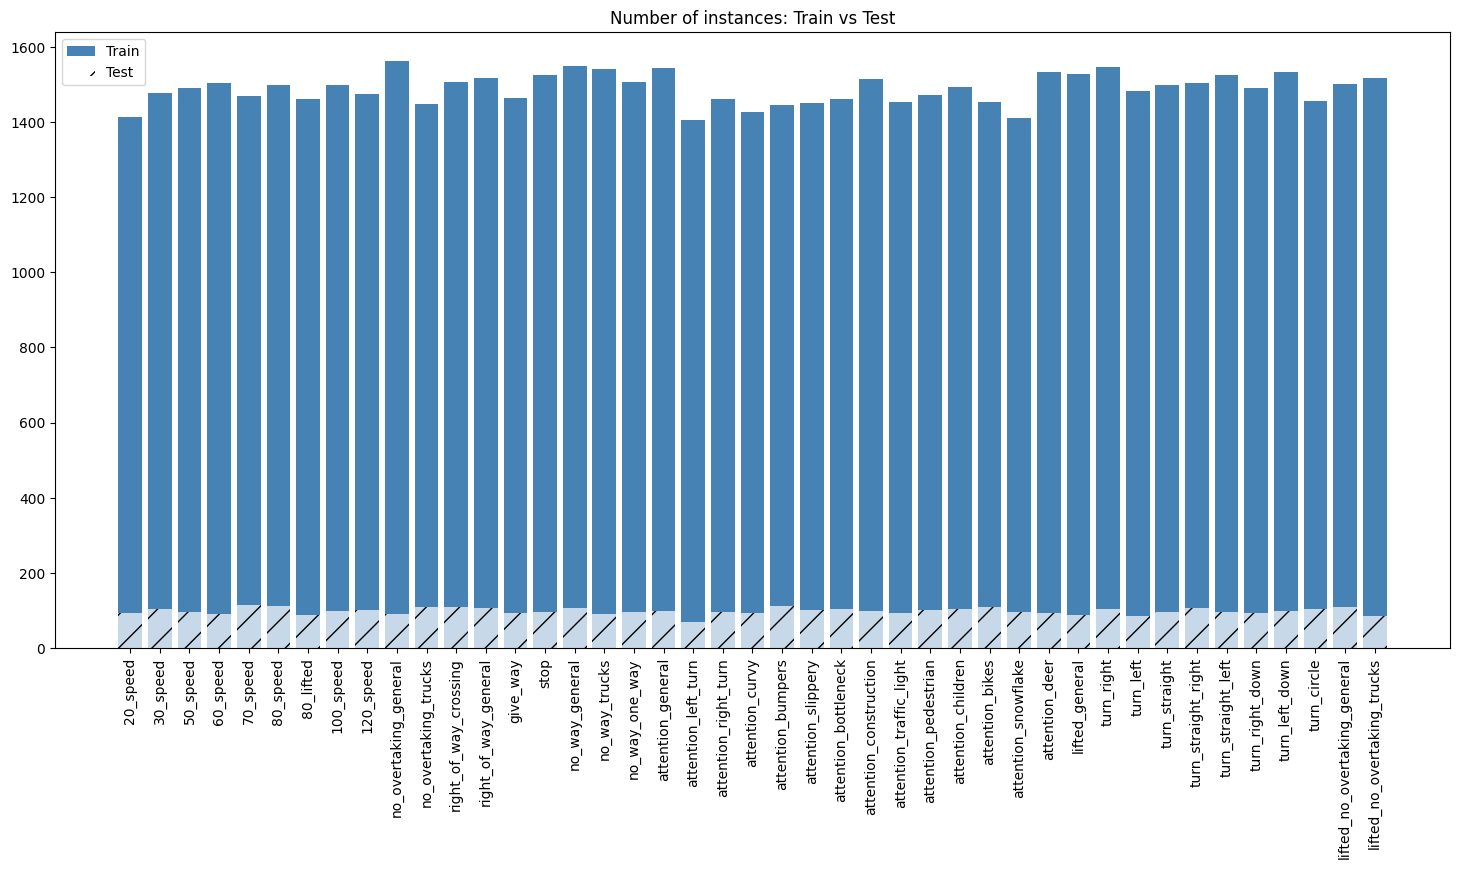

In [34]:
plt.figure(figsize=(18, 8))
plt.bar(height=balanced_collat_classes_train, x=list(feature_names.values()), color='steelblue', label='Train')
plt.bar(height=balanced_collat_classes_test, x=list(feature_names.values()),  alpha=.70, hatch='/', color='white', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.title('Number of instances: Train vs Test')
plt.show()

# Saving augmented images

In [144]:
def save_augmented_images(dataloader, mode):
    # train or test
    if mode=='train':
        folder_name = 'trainingset'
        csv_name = 'training.csv'
    else:
        folder_name = 'testset'
        csv_name = 'test.csv'
        
    
    # create parent folder
    folder_path = path_data / 'gtsrb_aug'
    folder_path.mkdir(exist_ok=True)
    
    # create train/test folder
    trainfolder_path = folder_path / folder_name
    trainfolder_path.mkdir(exist_ok=True)

    # create subfolder for each class (train only)
    range_num_classes = range(43)
    for i in range_num_classes:
        (trainfolder_path / str(i)).mkdir(exist_ok=True)
        
    # counter
    counter = {i: 0 for i in range_num_classes}
    
    # create csv file
    f = trainfolder_path / csv_name
    f.touch()
    
    # progress bar
    pb = progress_bar( range(len(dataloader)) )
    
    # save image and csv row record
    with f.open('w+', newline='') as ff:
        writer = csv.writer(ff)
        # writer.writerow(['label', 'path'])
        for _, (img, label) in zip(pb, dataloader): # get batches
            for i, l in zip(img, label): # loop over images
                # scale all data using min max
                img = (img - img.amin(dim, keepdim=True)) / (img.amax(dim, keepdim=True) - img.amin(dim, keepdim=True))
                # move to gpu
#                 img, label = img.to(device), label.to(device)
                # image name
                img_name = f"{str(l.item()).zfill(2)}_{str(counter[l.item()]).zfill(4)}"           
                # convert image to PIL to save as ppm
                T.ToPILImage()(i).save(trainfolder_path / str(l.item()) / f'{img_name}.ppm' )
                # write row
                writer.writerow([str(l.item()), f'{str(l.item())}/{img_name}.ppm'])
                # +1 to class in counter
                counter[l.item()] += 1

In [145]:
save_augmented_images(train_weighted_loader, 'train')

In [146]:
save_augmented_images(test_weighted_loader, 'test')

In [147]:
train_data_aug = pd.read_csv(path_data / 'gtsrb_aug' / 'trainingset' / 'training.csv', header=None)[0].value_counts().sort_index()
test_data_aug = pd.read_csv(path_data / 'gtsrb_aug' / 'testset' / 'test.csv', header=None)[0].value_counts().sort_index()

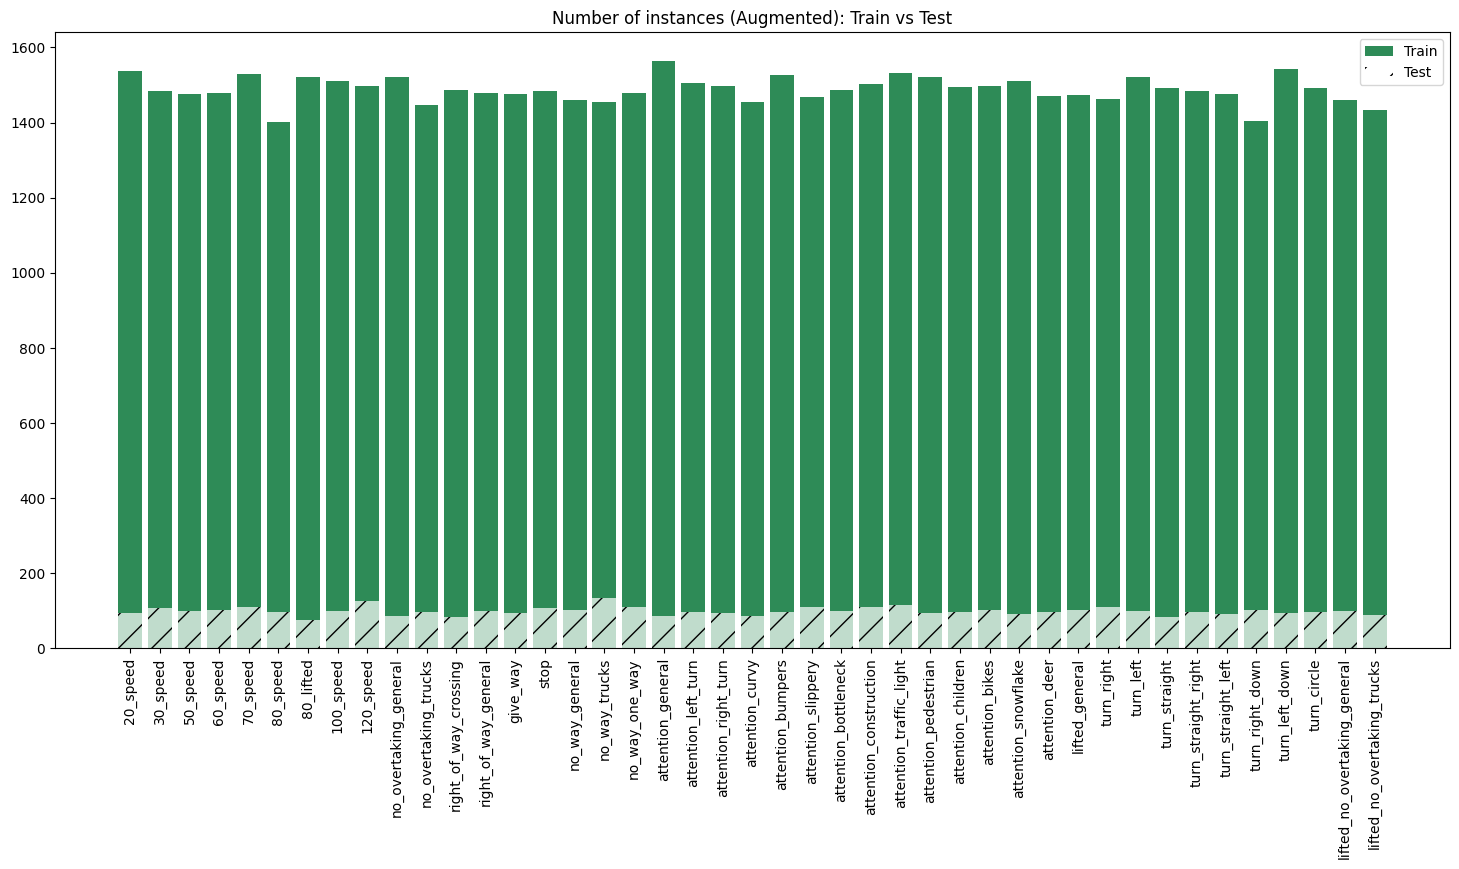

In [148]:
plt.figure(figsize=(18, 8))
plt.bar(height=train_data_aug, x=list(feature_names.values()), color='seagreen', label='Train')
plt.bar(height=test_data_aug, x=list(feature_names.values()),  alpha=.70, hatch='/', color='white', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.title('Number of instances (Augmented): Train vs Test')
plt.show()